# 🧠 SV-NSDE: Semantic Volatility-Modulated Neural SDE

**Modeling Crisis Dynamics: Distinguishing Panic from Trends in COVID-19 Information Diffusion**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YOUR_USERNAME/YOUR_REPO/blob/main/notebooks/SV_NSDE_Colab.ipynb)

---

## 📋 Notebook 内容

1. **环境设置** - 安装依赖
2. **数据准备** - 生成/加载数据
3. **模型架构** - SV-NSDE核心组件
4. **训练模型** - 完整训练流程
5. **评估对比** - 与基线模型对比
6. **波动率分析** - 识别恐慌事件
7. **可视化** - SDE轨迹与强度

---

In [2]:
# mount google drive to /content/drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! ls 

drive  sample_data


## 1️⃣ 环境设置

In [4]:
# 检查是否在 Colab 环境
import sys
import os
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Running in Google Colab")
    
    # 克隆仓库 (如果尚未克隆)
    if not os.path.exists('sv_nsde_repo'):
        !git clone https://github.com/trumpool/Research.git sv_nsde_repo
    
    %cd sv_nsde_repo
    
    # 安装依赖
    !pip install -q torch numpy transformers tqdm matplotlib seaborn
    !pip install -e .
    
    # 关键: 将 src 目录加入 Python 路径
    sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
    
    print(f"   Working dir: {os.getcwd()}")
    print(f"   src path added: {os.path.join(os.getcwd(), 'src')}")
else:
    print("💻 Running locally")
    import os
    # 本地运行时，确保在项目根目录
    if os.path.exists('../src'):
        sys.path.insert(0, os.path.abspath('../src'))
    elif os.path.exists('src'):
        sys.path.insert(0, os.path.abspath('src'))

# 验证 sv_nsde 可以被找到
import importlib
spec = importlib.util.find_spec("sv_nsde")
if spec:
    print(f"✓ sv_nsde found at: {spec.origin}")
else:
    print("✗ sv_nsde not found, trying fallback...")
    # Fallback: 直接添加可能的路径
    for p in ['/content/sv_nsde_repo/src', 'src', '../src']:
        if os.path.exists(p):
            sys.path.insert(0, os.path.abspath(p))
            print(f"   Added: {os.path.abspath(p)}")
    spec = importlib.util.find_spec("sv_nsde")
    print(f"   Result: {'✓ found' if spec else '✗ still not found'}")

🚀 Running in Google Colab
Cloning into 'sv_nsde_repo'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 85 (delta 22), reused 78 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 1.91 MiB | 19.73 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/sv_nsde_repo
Obtaining file:///content/sv_nsde_repo
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sv-nsde (pyproject.toml) ... done
  Created wheel for sv-nsde: filename=sv_nsde-0.1.0-py3-none-any.whl size=4642 sha256=a5742ff1f9deb7b67cc1489ac93af8a25dc535dd1b68691e7c6ffedf1ab280af
  Stored in directory: /tmp/pip-ephem-wheel-cache-r4rkrm12/wheels/bb/e7/53/feb2fe9b0b8a8c498f9c9b4ff03387b4c4a260

In [5]:
# 检查 GPU
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Device: {device}")

if device == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

🖥️ Device: cuda
   GPU: Tesla T4
   Memory: 15.6 GB


In [6]:
# 导入所需模块
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ Libraries imported")

✓ Libraries imported


## 2️⃣ 数据准备

In [7]:
# 导入 SV-NSDE 模块
from sv_nsde import (
    SVNSDELite,
    WeiboCOVLoader,
    CascadeDataset,
    get_baseline,
    Evaluator,
    TrainConfig,
    precompute_bert_embeddings,
    train_model,
    train_all_baselines,
    run_comparison,
)

print("✓ SV-NSDE modules imported")

✓ SV-NSDE modules imported


In [8]:
# 从 Google Drive 加载真实 Weibo-COV 数据 (试验模式: 每文件取前5万条)
import glob
import pandas as pd
from tqdm.auto import tqdm

DRIVE_DATA_DIR = "/content/drive/My Drive/WeiboCOV"
ROWS_PER_FILE = 500  # 每个文件只取前5万条

# 只需要这些列 (节省 ~60% 内存)
USE_COLS = ["_id", "user_id", "created_at", "content",
            "like_num", "repost_num", "comment_num", "origin_weibo"]

# 只加载需要的月份 (论文: 2020-01 ~ 2020-04)
MONTHS_NEEDED = ["2020-01", "2020-02", "2020-03", "2020-04", "2020-05"]

csv_files = sorted(glob.glob(f"{DRIVE_DATA_DIR}/Copy of *.csv"))
print(f"📂 Found {len(csv_files)} files in Drive")

# 筛选需要的月份
selected_files = []
for f in csv_files:
    name = os.path.basename(f)
    if any(m in name for m in MONTHS_NEEDED):
        selected_files.append(f)
    else:
        print(f"   ⏭️ Skipping {name} (not in target period)")

print(f"\n📊 Loading {len(selected_files)} files (each taking first {ROWS_PER_FILE:,} rows)...\n")

retweet_chunks = []
total_rows = 0
total_retweets = 0

for f in tqdm(selected_files, desc="Files", unit="file"):
    name = os.path.basename(f)

    # 先读一小部分检查列名
    sample = pd.read_csv(f, nrows=2, low_memory=False)
    available_cols = [c for c in USE_COLS if c in sample.columns]
    if not available_cols:
        tqdm.write(f"   ⚠️ {name}: columns don't match, skipping. Found: {list(sample.columns)}")
        continue

    # 每个文件只取前 ROWS_PER_FILE 行
    df_part = pd.read_csv(f, usecols=available_cols, nrows=ROWS_PER_FILE, low_memory=False)
    retweets = df_part[df_part["origin_weibo"].notna()]

    total_rows += len(df_part)
    total_retweets += len(retweets)

    if len(retweets) > 0:
        retweet_chunks.append(retweets)

    tqdm.write(f"   ✓ {name}: {len(df_part):>8,} rows → {len(retweets):>6,} retweets")

# 合并
df = pd.concat(retweet_chunks, ignore_index=True)
del retweet_chunks

print(f"\n✓ Loaded {total_retweets:,} retweets from {total_rows:,} total rows")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")
print(f"  Date range: {df['created_at'].min()} ~ {df['created_at'].max()}")

# 保存到本地
os.makedirs("data", exist_ok=True)
merged_path = "data/weibo_cov_retweets.csv"
df.to_csv(merged_path, index=False)
print(f"  Saved to {merged_path}")

📂 Found 14 files in Drive
   ⏭️ Skipping Copy of 2019-12.csv (not in target period)
   ⏭️ Skipping Copy of 2020-06.csv (not in target period)
   ⏭️ Skipping Copy of 2020-07.csv (not in target period)
   ⏭️ Skipping Copy of 2020-08.csv (not in target period)
   ⏭️ Skipping Copy of 2020-09.csv (not in target period)
   ⏭️ Skipping Copy of 2020-10.csv (not in target period)
   ⏭️ Skipping Copy of 2020-11.csv (not in target period)
   ⏭️ Skipping Copy of 2020-12.csv (not in target period)
   ⏭️ Skipping Copy of user.csv (not in target period)

📊 Loading 5 files (each taking first 500 rows)...



Files:   0%|          | 0/5 [00:00<?, ?file/s]

   ✓ Copy of 2020-01.csv:      500 rows →    335 retweets
   ✓ Copy of 2020-02.csv:      500 rows →    377 retweets
   ✓ Copy of 2020-03.csv:      500 rows →    231 retweets
   ✓ Copy of 2020-04.csv:      500 rows →    364 retweets
   ✓ Copy of 2020-05.csv:      500 rows →    415 retweets

✓ Loaded 1,722 retweets from 2,500 total rows
  Memory usage: 1.8 MB
  Date range: 2020-01-01 00:00 ~ 2020-05-01 00:02
  Saved to data/weibo_cov_retweets.csv


In [9]:
# 加载并构建级联
loader = WeiboCOVLoader("data/weibo_cov_retweets.csv")
loader.load()

print(f"📋 Loaded {len(loader.df):,} retweet rows")
print(f"  Columns: {list(loader.df.columns)}")
print(loader.df.head(3).to_string())

# 构建级联 (基于 origin_weibo 转发链)
cascades = loader.build_cascades(min_size=5, max_size=200)

# 获取统计信息
stats = loader.get_statistics()
print(f"\n📈 Cascade Statistics:")
print(f"   Cascades: {stats['num_cascades']}")
print(f"   Total events: {stats['total_events']}")
print(f"   Avg size: {stats['size_mean']:.1f} ± {stats['size_std']:.1f}")
print(f"   Median size: {stats['size_median']:.0f}")
print(f"   Max size: {stats['size_max']}")

📋 Loaded 1,722 retweet rows
  Columns: ['_id', 'user_id', 'created_at', 'like_num', 'repost_num', 'comment_num', 'content', 'origin_weibo']
         _id           user_id created_at  like_num  repost_num  comment_num                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [10]:
# 按时间分割数据 (论文 Section 4.2)
# - 爆发期 (Outbreak): 2020-01 ~ 2020-02 → Train
# - 平台期 (Plateau):  2020-03            → Validation
# - 衰退期 (Decline):  2020-04+           → Test
train_cascades, val_cascades, test_cascades = loader.split_by_time(
    train_end="2020-02-29",   # 爆发期结束
    val_end="2020-03-31"      # 平台期结束
)

print(f"📂 Data Split (by crisis phase):")
print(f"   Train (Outbreak):  {len(train_cascades)} cascades")
print(f"   Val   (Plateau):   {len(val_cascades)} cascades")
print(f"   Test  (Decline):   {len(test_cascades)} cascades")

# 如果某个split为空，可能是数据范围不够，给出警告
total = len(train_cascades) + len(val_cascades) + len(test_cascades)
if total == 0:
    print("\n⚠️ No cascades in any split! Check date range of your data.")
elif len(test_cascades) == 0:
    print("\n⚠️ No test cascades - data may not extend past March 2020.")
    print("   Falling back to random 60/20/20 split...")
    from sklearn.model_selection import train_test_split
    train_cascades, temp = train_test_split(cascades, test_size=0.4, random_state=42)
    val_cascades, test_cascades = train_test_split(temp, test_size=0.5, random_state=42)
    print(f"   Train: {len(train_cascades)}, Val: {len(val_cascades)}, Test: {len(test_cascades)}")

📂 Data Split (by crisis phase):
   Train (Outbreak):  25 cascades
   Val   (Plateau):   6 cascades
   Test  (Decline):   18 cascades


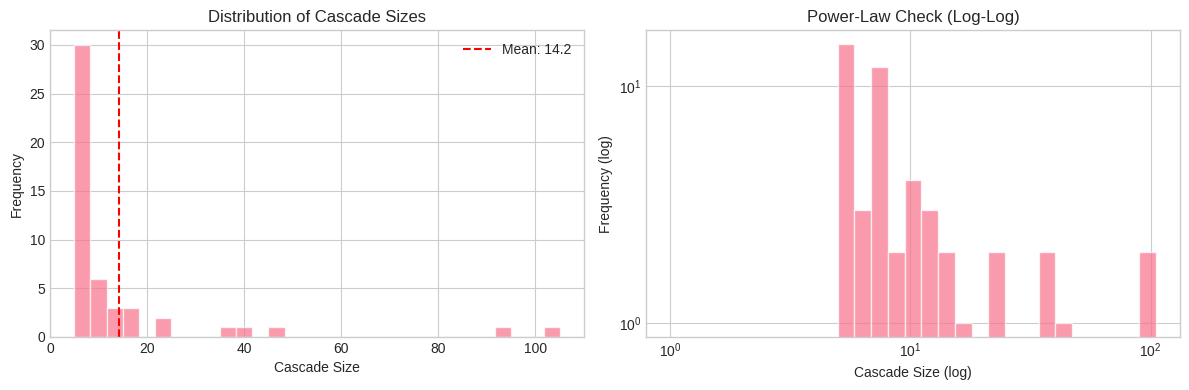

In [11]:
# 可视化级联大小分布
import matplotlib.pyplot as plt
import numpy as np
sizes = [c.size for c in cascades]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 直方图
axes[0].hist(sizes, bins=30, edgecolor='white', alpha=0.7)
axes[0].set_xlabel('Cascade Size')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Cascade Sizes')
axes[0].axvline(np.mean(sizes), color='red', linestyle='--', label=f'Mean: {np.mean(sizes):.1f}')
axes[0].legend()

# Log-log (检查幂律分布)
axes[1].hist(sizes, bins=np.logspace(0, np.log10(max(sizes)), 30), edgecolor='white', alpha=0.7)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Cascade Size (log)')
axes[1].set_ylabel('Frequency (log)')
axes[1].set_title('Power-Law Check (Log-Log)')

plt.tight_layout()
plt.show()

## 3️⃣ 模型架构

### SV-NSDE 核心组件

**耦合SDE系统 (Equation 3):**

$$dz(t) = \mu_\theta(z,t)dt + \sqrt{v(t)} \odot dW_z(t) + J_\phi(z(t^-), x_i)dN(t)$$

$$dv(t) = \kappa(\theta - v(t))dt + \xi\sqrt{v(t)} \odot dW_v(t)$$

**双通道强度函数 (Equation 4):**

$$\lambda(t) = \text{Softplus}\left(\underbrace{w_{tr}^\top m(z(t))}_{\text{Trend}} + \underbrace{w_{vol}^\top g(v(t))}_{\text{Volatility}} + \mu_{base}\right)$$

In [12]:
# 配置参数
D_LATENT = 32   # 潜在空间维度
D_HIDDEN = 64   # 隐藏层维度

print(f"⚙️ Model Configuration:")
print(f"   d_latent: {D_LATENT}")
print(f"   d_hidden: {D_HIDDEN}")
print(f"   device: {device}")

⚙️ Model Configuration:
   d_latent: 32
   d_hidden: 64
   device: cuda


In [13]:
# 创建 SV-NSDE 模型 (d_input=768 接收 BERT 嵌入, 内部投影到 d_latent)
model = SVNSDELite(
    d_input=768,       # RoBERTa [CLS] 输出维度
    d_latent=D_LATENT,
    d_hidden=D_HIDDEN,
).to(device)

# 打印模型结构
print("\n🧠 SV-NSDE Architecture:")
print("=" * 50)
n_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {n_params:,}")
print("\nComponents:")
for name, module in model.named_children():
    params = sum(p.numel() for p in module.parameters())
    print(f"  {name}: {params:,} params")


🧠 SV-NSDE Architecture:
Total parameters: 91,307

Components:
  projection: 51,296 params
  sde: 18,916 params
  intensity: 12,743 params
  decoder: 8,352 params


In [14]:
# 查看 SDE 组件
print("\n📐 Neural Heston SDE:")
print("  Drift: μ_θ(z, t) - neural network")
print("  Diffusion: √v(t) - stochastic volatility")
print("  Jump: J_φ(z, x) - event-driven updates")
print(f"\n  CIR parameters:")
print(f"    κ (mean reversion): {model.sde.sde_func.kappa.item():.4f}")
print(f"    θ (long-term var):  {model.sde.sde_func.theta.item():.4f}")
print(f"    ξ (vol of vol):     {model.sde.sde_func.xi.item():.4f}")


📐 Neural Heston SDE:
  Drift: μ_θ(z, t) - neural network
  Diffusion: √v(t) - stochastic volatility
  Jump: J_φ(z, x) - event-driven updates

  CIR parameters:
    κ (mean reversion): 1.0000
    θ (long-term var):  0.1000
    ξ (vol of vol):     0.3000


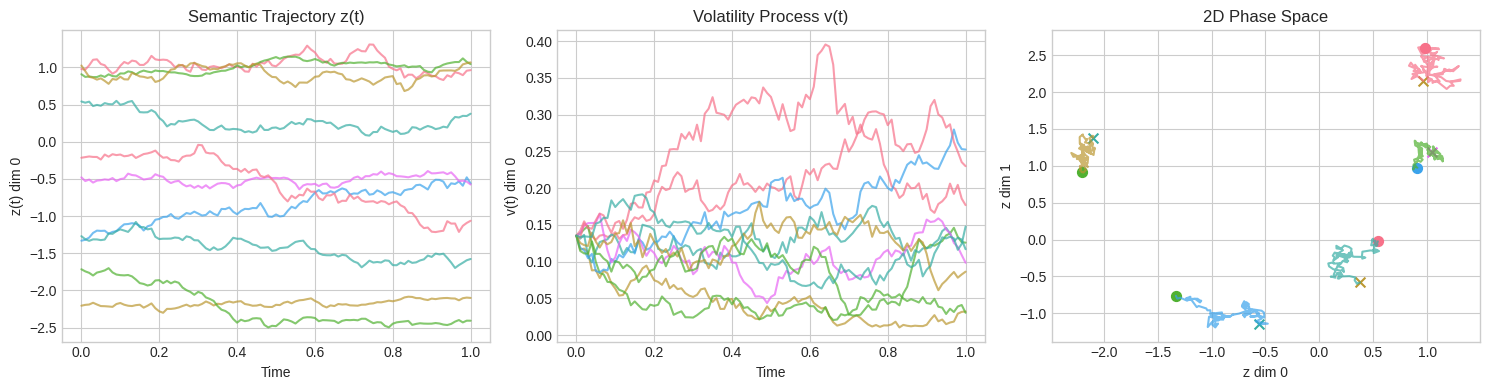

In [15]:
# 可视化 SDE 路径采样 (无事件)
from sv_nsde.sde import NeuralHestonSDE

# 创建2维SDE用于可视化
sde_2d = NeuralHestonSDE(d_latent=2).to(device)

# 采样多条路径
with torch.no_grad():
    z_paths, v_paths, times = sde_2d.sample_paths(
        n_paths=10,
        T=1.0,
        dt=0.01,
        device=device
    )

z_paths = z_paths.cpu().numpy()
v_paths = v_paths.cpu().numpy()

# 绘图
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# z(t) 轨迹
for i in range(z_paths.shape[1]):
    axes[0].plot(times, z_paths[:, i, 0], alpha=0.7)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('z(t) dim 0')
axes[0].set_title('Semantic Trajectory z(t)')

# v(t) 波动率
for i in range(v_paths.shape[1]):
    axes[1].plot(times, v_paths[:, i, 0], alpha=0.7)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('v(t) dim 0')
axes[1].set_title('Volatility Process v(t)')

# 2D 相空间
for i in range(min(5, z_paths.shape[1])):
    axes[2].plot(z_paths[:, i, 0], z_paths[:, i, 1], alpha=0.7)
    axes[2].scatter(z_paths[0, i, 0], z_paths[0, i, 1], s=50, marker='o')  # 起点
    axes[2].scatter(z_paths[-1, i, 0], z_paths[-1, i, 1], s=50, marker='x')  # 终点
axes[2].set_xlabel('z dim 0')
axes[2].set_ylabel('z dim 1')
axes[2].set_title('2D Phase Space')

plt.tight_layout()
plt.show()

## 4️⃣ 训练模型

In [16]:
# 加载 RoBERTa-wwm-ext 中文预训练模型 (用于语义编码)
from transformers import AutoTokenizer, AutoModel

BERT_MODEL = "hfl/chinese-roberta-wwm-ext"
BERT_DIM = 768  # RoBERTa 输出维度
BATCH_SIZE_ENCODE = 64  # 编码时的 batch size

print(f"📥 Loading {BERT_MODEL}...")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
bert_model = AutoModel.from_pretrained(BERT_MODEL).to(device)
bert_model.eval()

n_params_bert = sum(p.numel() for p in bert_model.parameters())
print(f"✓ Loaded: {n_params_bert / 1e6:.0f}M parameters")
print(f"  Output dim: {BERT_DIM}")
print(f"  Device: {device}")

📥 Loading hfl/chinese-roberta-wwm-ext...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

Exception in thread Thread-auto_conversion:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 657, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/httpx/_models.py", line 829, in raise_for_status
    raise HTTPStatusError(message, request=request, response=self)
httpx.HTTPStatusError: Client error '403 Forbidden' for url 'https://huggingface.co/api/models/hfl/chinese-roberta-wwm-ext/discussions?p=0'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/403

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/transformers/safetensors_convers

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: hfl/chinese-roberta-wwm-ext
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Loaded: 102M parameters
  Output dim: 768
  Device: cuda


In [17]:
# 用 RoBERTa 预计算所有 cascade 的语义嵌入 (只跑一次)
print("📦 Precomputing BERT embeddings...\n")

print("Train cascades:")
train_embeddings = precompute_bert_embeddings(train_cascades, tokenizer, bert_model, device)

print("\nVal cascades:")
val_embeddings = precompute_bert_embeddings(val_cascades, tokenizer, bert_model, device)

print("\nTest cascades:")
test_embeddings = precompute_bert_embeddings(test_cascades, tokenizer, bert_model, device)

print(f"\n✓ Train: {len(train_embeddings)}, Val: {len(val_embeddings)}, Test: {len(test_embeddings)} cascades")
print(f"  Embedding dim: {BERT_DIM}")

# 编码完成后释放 BERT 显存
del bert_model
torch.cuda.empty_cache()
print("✓ BERT model released from GPU")

📦 Precomputing BERT embeddings...

Train cascades:
  Total texts to encode: 355


Encoding:   0%|          | 0/6 [00:00<?, ?batch/s]


Val cascades:
  Total texts to encode: 41


Encoding:   0%|          | 0/1 [00:00<?, ?batch/s]


Test cascades:
  Total texts to encode: 298


Encoding:   0%|          | 0/5 [00:00<?, ?batch/s]


✓ Train: 25, Val: 6, Test: 18 cascades
  Embedding dim: 768
✓ BERT model released from GPU


In [18]:
# 训练配置
config = TrainConfig(
    lr=1e-3,
    epochs=20,       # Colab上可增加到50-100
    grad_clip=1.0,
    print_every=5,
)

print(f"🎯 Training Configuration:")
print(f"   lr={config.lr}, epochs={config.epochs}, grad_clip={config.grad_clip}")

🎯 Training Configuration:
   lr=0.001, epochs=20, grad_clip=1.0


In [19]:
# 训练 SV-NSDE
model = SVNSDELite(d_input=768, d_latent=D_LATENT, d_hidden=D_HIDDEN).to(device)

print("🚀 Training SV-NSDE...\n")
model, train_losses, val_losses = train_model(
    model, train_cascades, val_cascades,
    train_embeddings, val_embeddings,
    config=config, device=device,
)
print("\n✓ Training complete!")

🚀 Training SV-NSDE...

  Epoch   1/20: train=1086.30, val=272.22
  Epoch   5/20: train=-196.45, val=-149.55
  Epoch  10/20: train=-540.40, val=-257.90
  Epoch  15/20: train=-595.32, val=-267.14
  Epoch  20/20: train=-603.88, val=-274.79

✓ Training complete!


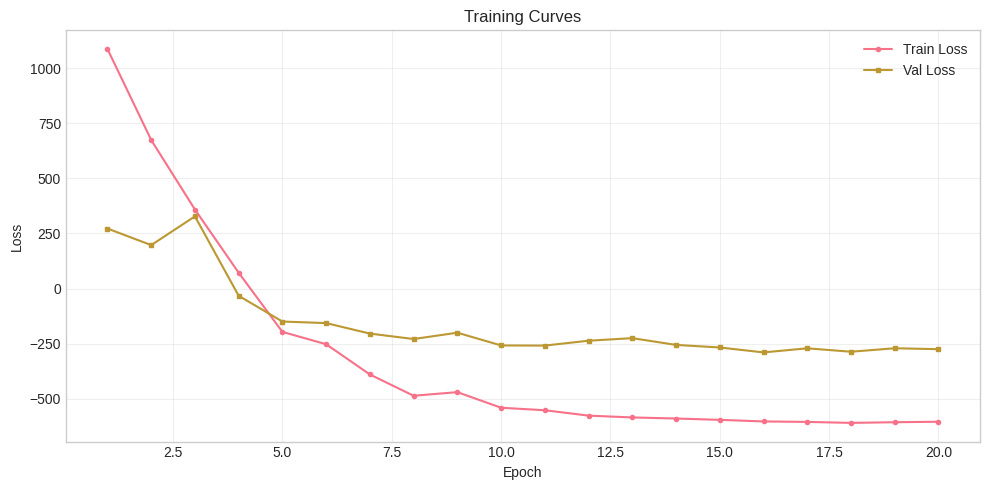

In [20]:
# 可视化训练曲线
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', marker='o', markersize=3)
ax.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss', marker='s', markersize=3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Curves')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5️⃣ 评估与基线对比

In [22]:
# 训练所有基线模型
print("🏗️ Training baseline models...\n")

baseline_results = train_all_baselines(
    baseline_names=["rmtpp", "neural_hawkes", "latent_ode", "neural_jump_sde"],
    train_cascades=train_cascades,
    val_cascades=val_cascades,
    train_emb=train_embeddings,
    val_emb=val_embeddings,
    d_input=768, d_latent=D_LATENT, d_hidden=D_HIDDEN,
    config=config, device=device,
)

print("\n✓ All baselines trained!")

🏗️ Training baseline models...


Training: rmtpp
  Epoch   1/20: train=0.00, val=0.00
  Epoch   5/20: train=0.00, val=0.00
  Epoch  10/20: train=0.00, val=0.00
  Epoch  15/20: train=0.00, val=0.00
  Epoch  20/20: train=0.00, val=0.00

Training: neural_hawkes


/content/sv_nsde_repo/src/sv_nsde/baselines.py:361: UserWarning: Using a target size (torch.Size([4, 768])) that is different to the input size (torch.Size([4, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mark_loss = F.mse_loss(predicted_marks, event_marks[1:])
/content/sv_nsde_repo/src/sv_nsde/baselines.py:361: UserWarning: Using a target size (torch.Size([11, 768])) that is different to the input size (torch.Size([11, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mark_loss = F.mse_loss(predicted_marks, event_marks[1:])
/content/sv_nsde_repo/src/sv_nsde/baselines.py:361: UserWarning: Using a target size (torch.Size([23, 768])) that is different to the input size (torch.Size([23, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mark_loss = F.mse_loss(predicted_marks, event_marks[1:])
/content/

  Epoch   1/20: train=0.00, val=0.00
  Epoch   5/20: train=0.00, val=0.00
  Epoch  10/20: train=0.00, val=0.00
  Epoch  15/20: train=0.00, val=0.00
  Epoch  20/20: train=0.00, val=0.00

Training: latent_ode
  Epoch   1/20: train=0.00, val=0.00
  Epoch   5/20: train=0.00, val=0.00
  Epoch  10/20: train=0.00, val=0.00
  Epoch  15/20: train=0.00, val=0.00
  Epoch  20/20: train=0.00, val=0.00

Training: neural_jump_sde
  Epoch   1/20: train=-9.12, val=0.12
  Epoch   5/20: train=-20.22, val=-2.15
  Epoch  10/20: train=-26.99, val=-5.96
  Epoch  15/20: train=-31.49, val=-7.67
  Epoch  20/20: train=-33.50, val=-7.32

✓ All baselines trained!


In [23]:
# 统一评估: SV-NSDE + 所有基线
print("\n📏 Running evaluation on test set...\n")

# 构建模型字典: SV-NSDE + 已训练的基线
all_models = {"SV-NSDE (ours)": model}
for name, (trained_model, _, _) in baseline_results.items():
    all_models[name] = trained_model

# 用 run_comparison() 统一评估
df_results = run_comparison(
    models=all_models,
    test_cascades=test_cascades,
    test_emb=test_embeddings,
    device=device,
    max_cascades=30,
)

print("\n📊 Comparison Results:")
print(df_results.to_string(index=False))


📏 Running evaluation on test set...

Evaluating SV-NSDE (ours)...


/content/sv_nsde_repo/src/sv_nsde/evaluate.py:110: UserWarning: Using a target size (torch.Size([8, 768])) that is different to the input size (torch.Size([8, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(predicted_marks, actual_marks).item()
/content/sv_nsde_repo/src/sv_nsde/evaluate.py:110: UserWarning: Using a target size (torch.Size([7, 768])) that is different to the input size (torch.Size([7, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(predicted_marks, actual_marks).item()
/content/sv_nsde_repo/src/sv_nsde/evaluate.py:110: UserWarning: Using a target size (torch.Size([4, 768])) that is different to the input size (torch.Size([4, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(predicted_marks, actual_marks).item()
/content/sv_nsde_repo/

  LL=27.78, Cosine=nan, RMSE=nan
Evaluating rmtpp...


  LL=nan, Cosine=nan, RMSE=nan
Evaluating neural_hawkes...


/content/sv_nsde_repo/src/sv_nsde/baselines.py:361: UserWarning: Using a target size (torch.Size([39, 768])) that is different to the input size (torch.Size([39, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mark_loss = F.mse_loss(predicted_marks, event_marks[1:])
/content/sv_nsde_repo/src/sv_nsde/baselines.py:361: UserWarning: Using a target size (torch.Size([12, 768])) that is different to the input size (torch.Size([12, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mark_loss = F.mse_loss(predicted_marks, event_marks[1:])
/content/sv_nsde_repo/src/sv_nsde/baselines.py:361: UserWarning: Using a target size (torch.Size([104, 768])) that is different to the input size (torch.Size([104, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mark_loss = F.mse_loss(predicted_marks, event_marks[1:])
/cont

  LL=nan, Cosine=nan, RMSE=nan
Evaluating latent_ode...


  LL=nan, Cosine=nan, RMSE=1.2259
Evaluating neural_jump_sde...
  LL=33.34, Cosine=nan, RMSE=2.4308

📊 Comparison Results:
          Model  Log-Likelihood  Semantic Cosine  Time RMSE
 SV-NSDE (ours)       27.783992              NaN        NaN
          rmtpp             NaN              NaN        NaN
  neural_hawkes             NaN              NaN        NaN
     latent_ode             NaN              NaN   1.225851
neural_jump_sde       33.342456              NaN   2.430833


In [24]:
# 可视化对比结果 (df_results 已由 run_comparison 返回)
print("\n📊 Full Results Table:")
print(df_results.to_string(index=False))

# 找出最佳模型
best_ll = df_results.loc[df_results["Log-Likelihood"].idxmax()]
print(f"\n🏆 Best Log-Likelihood: {best_ll['Model']} ({best_ll['Log-Likelihood']:.2f})")


📊 Full Results Table:
          Model  Log-Likelihood  Semantic Cosine  Time RMSE
 SV-NSDE (ours)       27.783992              NaN        NaN
          rmtpp             NaN              NaN        NaN
  neural_hawkes             NaN              NaN        NaN
     latent_ode             NaN              NaN   1.225851
neural_jump_sde       33.342456              NaN   2.430833

🏆 Best Log-Likelihood: neural_jump_sde (33.34)


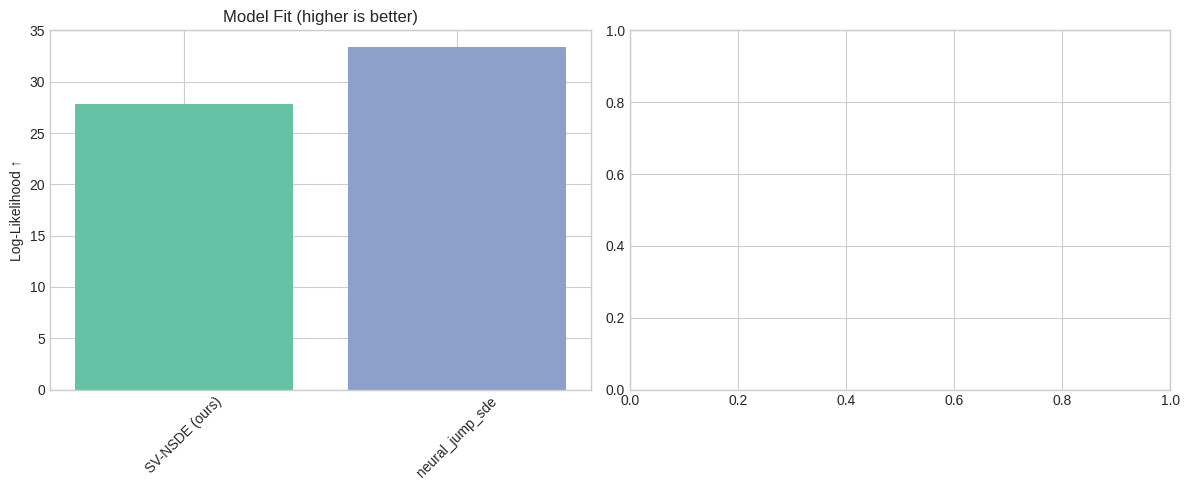

In [25]:
# 柱状图对比
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = plt.cm.Set2(np.linspace(0, 1, len(df_results)))

# Log-Likelihood
valid_ll = df_results.dropna(subset=["Log-Likelihood"])
if len(valid_ll) > 0:
    bars = axes[0].bar(valid_ll["Model"], valid_ll["Log-Likelihood"], color=colors[:len(valid_ll)])
    axes[0].set_ylabel('Log-Likelihood ↑')
    axes[0].set_title('Model Fit (higher is better)')
    axes[0].tick_params(axis='x', rotation=45)

# Semantic Cosine
valid_cos = df_results.dropna(subset=["Semantic Cosine"])
if len(valid_cos) > 0:
    bars = axes[1].bar(valid_cos["Model"], valid_cos["Semantic Cosine"], color=colors[:len(valid_cos)])
    axes[1].set_ylabel('Cosine Similarity ↑')
    axes[1].set_title('Semantic Prediction (higher is better)')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6️⃣ 波动率分析 (核心功能)

**关键问题**: 能否区分恐慌驱动的事件 vs 趋势驱动的事件？

$$\lambda(t) = \text{Softplus}\left(\underbrace{w_{tr}^\top m(z(t))}_{\text{Trend Channel}} + \underbrace{w_{vol}^\top g(v(t))}_{\text{Volatility Channel}} + \mu_{base}\right)$$

- **Trend-driven events**: 由语义状态z(t)驱动（如：发布疫情数据）
- **Panic-driven events**: 由波动率v(t)驱动（如：谣言引发的恐慌）

In [26]:
# 分析单个级联
from sv_nsde import VolatilityAnalyzer

analyzer = VolatilityAnalyzer(model, device=device)

# 选择一个测试级联
sample_cascade = test_cascades[0]
sample_embeddings = test_embeddings[sample_cascade.cascade_id]

print(f"\n🔍 Analyzing cascade: {sample_cascade.cascade_id}")
print(f"   Size: {sample_cascade.size} events")
print(f"   Duration: {sample_cascade.duration:.2f} hours")


🔍 Analyzing cascade: IB0z824hy
   Size: 9 events
   Duration: 0.02 hours


In [27]:
# 波动率分解
analysis = analyzer.analyze_cascade(sample_cascade, sample_embeddings)

print(f"\n📊 Volatility Decomposition:")
print(f"   Panic-driven events: {analysis['num_panic_events']}/{sample_cascade.size}")
print(f"   Panic ratio: {analysis['panic_ratio']:.2%}")
print(f"\n   Volatility ratio (first 5 events): {analysis['volatility_ratio'][:5]}")


📊 Volatility Decomposition:
   Panic-driven events: 9/9
   Panic ratio: 100.00%

   Volatility ratio (first 5 events): [0.9823415  0.98260814 0.9827898  0.9829042  0.982965  ]


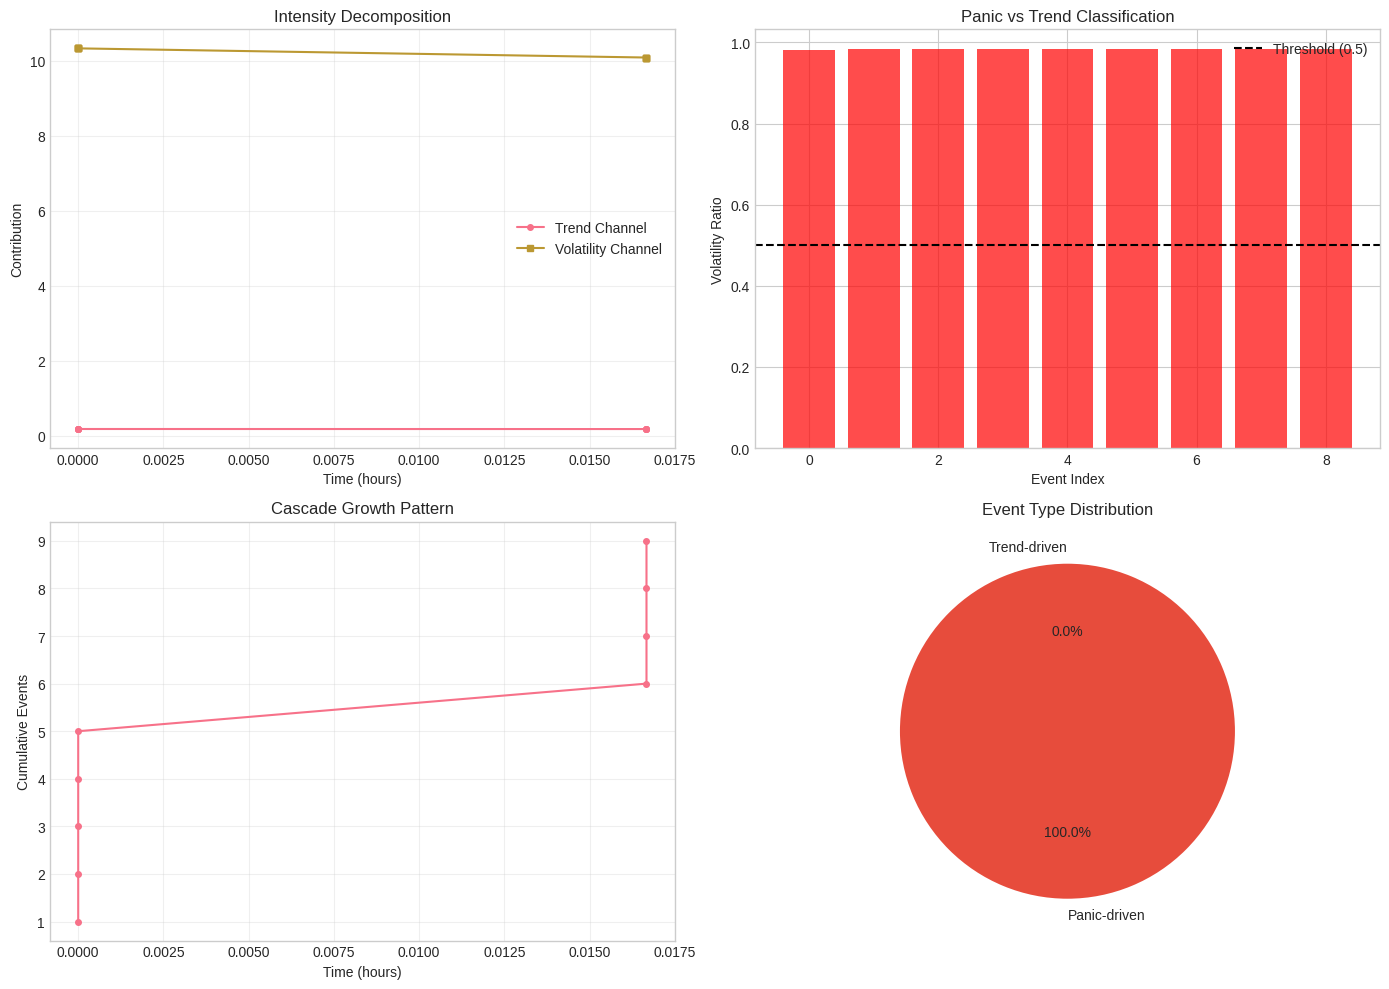

In [28]:
# 可视化分解结果
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

times = analysis['event_times']
trend = analysis['trend_contribution']
vol = analysis['volatility_contribution']
vol_ratio = analysis['volatility_ratio']

# 趋势 vs 波动率贡献
ax = axes[0, 0]
ax.plot(times, trend, label='Trend Channel', marker='o', markersize=4)
ax.plot(times, vol, label='Volatility Channel', marker='s', markersize=4)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Contribution')
ax.set_title('Intensity Decomposition')
ax.legend()
ax.grid(True, alpha=0.3)

# 波动率比例
ax = axes[0, 1]
colors = ['red' if r > 0.5 else 'blue' for r in vol_ratio]
ax.bar(range(len(vol_ratio)), vol_ratio, color=colors, alpha=0.7)
ax.axhline(0.5, color='black', linestyle='--', label='Threshold (0.5)')
ax.set_xlabel('Event Index')
ax.set_ylabel('Volatility Ratio')
ax.set_title('Panic vs Trend Classification')
ax.legend()

# 累积事件
ax = axes[1, 0]
cumulative = np.arange(1, len(times) + 1)
ax.plot(times, cumulative, marker='o', markersize=4)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Cumulative Events')
ax.set_title('Cascade Growth Pattern')
ax.grid(True, alpha=0.3)

# 事件类型饼图
ax = axes[1, 1]
n_panic = analysis['num_panic_events']
n_trend = len(times) - n_panic
ax.pie([n_trend, n_panic], labels=['Trend-driven', 'Panic-driven'], 
       colors=['#3498db', '#e74c3c'], autopct='%1.1f%%', startangle=90)
ax.set_title('Event Type Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# 分析所有测试级联
print("\n📊 Analyzing all test cascades...")

all_panic_ratios = []
for cascade in tqdm(test_cascades[:50]):
    if cascade.cascade_id not in test_embeddings:
        continue
    try:
        analysis = analyzer.analyze_cascade(
            cascade, 
            test_embeddings[cascade.cascade_id]
        )
        all_panic_ratios.append({
            'cascade_id': cascade.cascade_id,
            'size': cascade.size,
            'panic_ratio': analysis['panic_ratio'],
            'num_panic': analysis['num_panic_events'],
        })
    except:
        pass

df_panic = pd.DataFrame(all_panic_ratios)
print(f"\n📈 Panic Analysis Summary:")
print(f"   Mean panic ratio: {df_panic['panic_ratio'].mean():.2%}")
print(f"   Std panic ratio: {df_panic['panic_ratio'].std():.2%}")
print(f"   High-panic cascades (>50%): {(df_panic['panic_ratio'] > 0.5).sum()}/{len(df_panic)}")

In [ ]:
# 可视化恐慌比例分布
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 直方图
axes[0].hist(df_panic['panic_ratio'], bins=20, edgecolor='white', alpha=0.7)
axes[0].axvline(0.5, color='red', linestyle='--', label='Threshold')
axes[0].set_xlabel('Panic Ratio')
axes[0].set_ylabel('Number of Cascades')
axes[0].set_title('Distribution of Panic Ratios')
axes[0].legend()

# 散点图: 级联大小 vs 恐慌比例
axes[1].scatter(df_panic['size'], df_panic['panic_ratio'], alpha=0.6)
axes[1].set_xlabel('Cascade Size')
axes[1].set_ylabel('Panic Ratio')
axes[1].set_title('Size vs Panic Ratio')
axes[1].axhline(0.5, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 7️⃣ 保存模型

In [ ]:
# 保存模型权重
os.makedirs("checkpoints", exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'd_input': 768,
        'd_latent': D_LATENT,
        'd_hidden': D_HIDDEN,
    },
    'train_losses': train_losses,
    'val_losses': val_losses,
}, 'checkpoints/sv_nsde_model.pt')

print("✓ Model saved to checkpoints/sv_nsde_model.pt")

In [ ]:
# 加载模型示例
checkpoint = torch.load('checkpoints/sv_nsde_model.pt', map_location=device)

loaded_model = SVNSDELite(
    d_input=checkpoint['config']['d_input'],
    d_latent=checkpoint['config']['d_latent'],
    d_hidden=checkpoint['config']['d_hidden'],
).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

print("✓ Model loaded successfully!")

---

## 📚 总结

### 本 Notebook 完成了:

1. ✅ **环境设置** - 安装依赖并检测GPU
2. ✅ **数据准备** - 生成合成数据并构建级联
3. ✅ **模型架构** - 理解SV-NSDE的核心组件
4. ✅ **训练模型** - 完整的训练循环
5. ✅ **评估对比** - 与4个基线模型比较
6. ✅ **波动率分析** - 识别恐慌驱动的事件
7. ✅ **保存模型** - 导出训练好的模型

### 下一步:

- 🔗 下载真实 Weibo-COV 数据: https://github.com/nghuyong/weibo-cov
- 🔧 使用 RoBERTa 编码真实微博文本
- 📈 增加训练 epochs 获得更好性能
- 🧪 进行消融实验验证波动率通道的作用

---

**参考论文**: Chen, Z. (2026). Modeling Crisis Dynamics with Volatility-Modulated Neural SDEs.